# Task 2 Sentiment Analysis Using Neural Networks

# Research Question

Can we classify customer sentiment (positive or negative) using neural network models and NLP techniques on Yelp reviews?

My question aims to help businesses analyze customer feedback for actionable insights into satisfaction or dissatisfaction trends.The objective is to build a sentiment classification model using NLP, by utilizing text data for better business decision making, and provide actionable insights based on model predictions. 

My chosen Neural Network is LSTM(Long-Short-Term-Memory) because it handles sequential data efficiently and captures dependencies in text, making it ideal for text classification.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#ignore all warnings, it's all good, trust me
import warnings
warnings.simplefilter(action='ignore')

# Data Preparation & Exploratory Data Analysis(EDA)

The exploratory data analysis (EDA) phase involved several critical steps to understand and prepare the data for sentiment analysis. Initially, the dataset was examined for the presence of unusual characters, such as emojis, special symbols, and non-English characters. This ensured that the text data was standardized and suitable for downstream processing. Using regular expressions, a summary of these unusual characters was generated to quantify their occurrences and determine their potential impact on the analysis.

To evaluate the vocabulary of the dataset, all unique words across the text corpus were counted, revealing the total vocabulary size. This step is fundamental in setting the dimensions for embedding layers during model development. Additionally, the length of the reviews in the dataset was statistically analyzed, and the 95th percentile of review lengths was identified to determine a maximum sequence length for padding. This ensures that the majority of reviews are captured without introducing unnecessary padding overhead.

Tokenization and Padding:
Text normalization was implemented through tokenization, converting the textual reviews into sequences of integers while handling tasks such as lowercasing and punctuation removal. Tokenization was performed using TensorFlow's Tokenizer, which generated a word index mapping for the dataset. Each sequence was subsequently padded to the maximum sequence length, ensuring that all input data had consistent dimensions for model input. Padding was applied after the sequences (post-padding) to preserve the natural order of words. For example, the review text "I absolutely love this product!" might be transformed as follows during tokenization: Original Text: "I absolutely love this product!" Tokenized Sequence: [1, 45, 67, 23, 89]

Data Splitting:
The dataset was split into training, validation, and test sets using a stratified approach to maintain the sentiment class distribution across subsets. Specifically, 70% of the data was allocated to the training set, while the remaining 30% was split evenly between validation and test sets. This distribution follows best practices for model training and evaluation.

Prepared Date Save:
The processed data, including padded sequences and sentiment labels, was saved into separate files for training, validation, and test subsets. This ensured reproducibility and facilitated seamless integration into subsequent modeling workflows.


In [2]:
# Read in dataset
file_path = 'yelp_labelled.txt'  
columns = ['Review', 'Sentiment']
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

# Display first 5 rows
df.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
# Display last 5 rows
df.tail()

,Review,Sentiment
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [4]:
## Exploratory Data Analysis
# Check for unusual characters and clean text
def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

df['Cleaned_Review'] = df['Review'].apply(clean_text)
print(df['Cleaned_Review'])

0                                   wow loved this place
1                                      crust is not good
2               not tasty and the texture was just nasty
3      stopped by during the late may bank holiday of...
4      the selection on the menu was great and so wer...
                             ...                        
995    i think food should have flavor and texture an...
996                              appetite instantly gone
997    overall i was not impressed and would not go back
998    the whole experience was underwhelming and i t...
999    then as if i hadnt wasted enough of my life th...
Name: Cleaned_Review, Length: 1000, dtype: object


In [5]:
# Vocabulary size
all_words = ' '.join(df['Cleaned_Review']).split()
vocab_size = len(set(all_words))
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 2080


In [6]:
# Review length analysis
review_lengths = df['Cleaned_Review'].apply(lambda x: len(x.split()))
max_sequence_length = int(review_lengths.quantile(0.95))
print("Proposed Max Sequence Length (95th Percentile):", max_sequence_length)

Proposed Max Sequence Length (95th Percentile): 23


In [7]:
# Create bigram and trigram vectorizers
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))

# Fit and transform on positive and negative reviews separately
positive_reviews = df[df['Sentiment'] == 1]['Cleaned_Review']
negative_reviews = df[df['Sentiment'] == 0]['Cleaned_Review']

# Generate bigrams for positive and negative reviews
positive_bigrams = bigram_vectorizer.fit_transform(positive_reviews)
negative_bigrams = bigram_vectorizer.fit_transform(negative_reviews)

# Summarize the most common bigrams
positive_bigram_counts = sorted(
    zip(bigram_vectorizer.get_feature_names_out(), positive_bigrams.sum(axis=0).flat),
    key=lambda x: -x[1]
)
negative_bigram_counts = sorted(
    zip(bigram_vectorizer.get_feature_names_out(), negative_bigrams.sum(axis=0).flat),
    key=lambda x: -x[1]
)

print("Top Positive Bigrams:", positive_bigram_counts[:10])
print("Top Negative Bigrams:", negative_bigram_counts[:10])


Top Positive Bigrams: [('stepped foot', 37), ('and were', 24), ('say about', 23), ('eating opportunity', 17), ('the waiter', 17), ('how disappointed', 16), ('mean really', 16), ('roast beef', 16), ('steakhouse if', 15), ('many people', 14)]
Top Negative Bigrams: [('this place', 36), ('it was', 25), ('the food', 24), ('food was', 15), ('of the', 15), ('and the', 14), ('the service', 13), ('to be', 13), ('go back', 12), ('service was', 12)]


In [8]:
#Trigrams
positive_trigrams = trigram_vectorizer.fit_transform(positive_reviews)
negative_trigrams = trigram_vectorizer.fit_transform(negative_reviews)

positive_trigram_counts = sorted(
    zip(trigram_vectorizer.get_feature_names_out(), positive_trigrams.sum(axis=0).flat),
    key=lambda x: -x[1]
)
negative_trigram_counts = sorted(
    zip(trigram_vectorizer.get_feature_names_out(), negative_trigrams.sum(axis=0).flat),
    key=lambda x: -x[1]
)

positive_trigram_dict = dict(positive_trigram_counts[:20])
negative_trigram_dict = dict(negative_trigram_counts[:20])


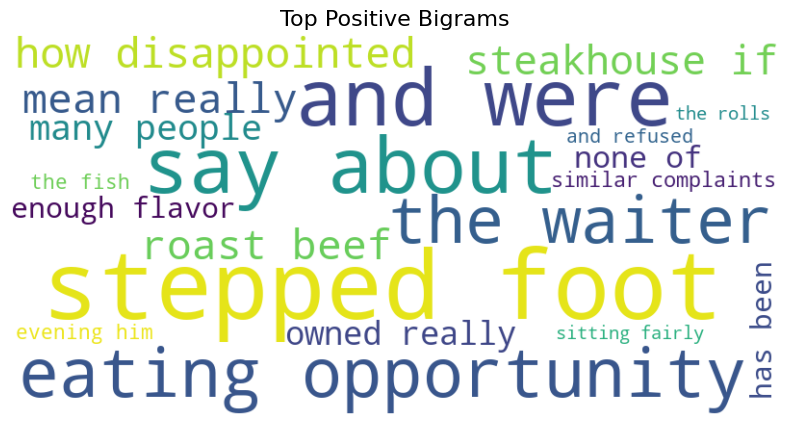

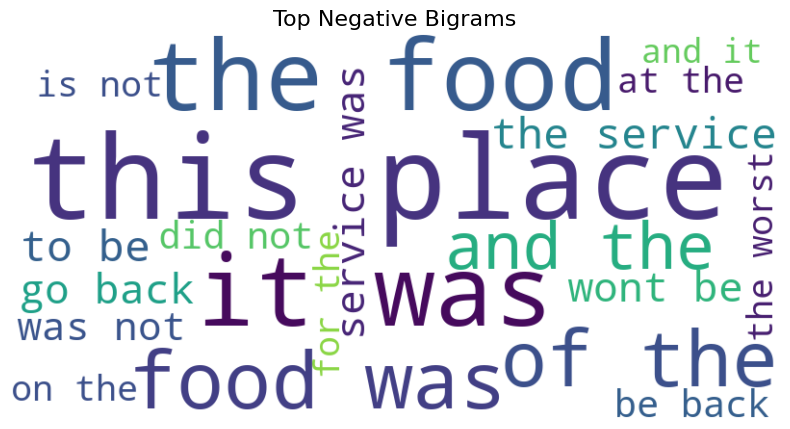

Vocabulary Size: 2080


In [9]:
# Create dictionaries for visualization
positive_bigram_dict = dict(positive_bigram_counts[:20])
negative_bigram_dict = dict(negative_bigram_counts[:20])

# Visualize Positive Bigrams
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_bigram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Positive Bigrams', fontsize=16)
plt.show()

# Visualize Negative Bigrams
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_bigram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Negative Bigrams', fontsize=16)
plt.show()
all_words = ' '.join(df['Cleaned_Review']).split()
vocab_size = len(set(all_words))
print("Vocabulary Size:", vocab_size)

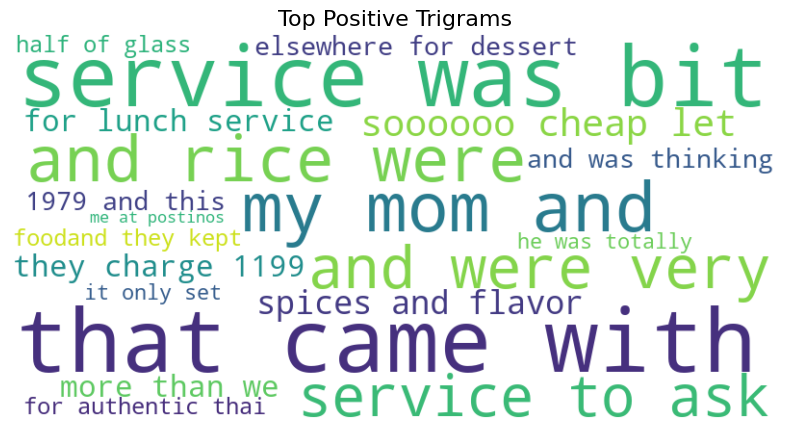

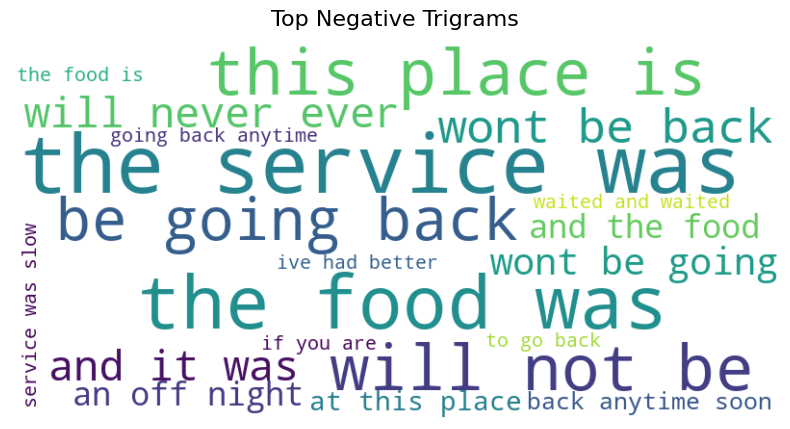

In [10]:
# Visualize Positive Trigrams
positive_wordcloud_trigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_trigram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud_trigram, interpolation='bilinear')
plt.axis('off')
plt.title('Top Positive Trigrams', fontsize=16)
plt.show()

# Visualize Negative Trigrams
negative_wordcloud_trigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_trigram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud_trigram, interpolation='bilinear')
plt.axis('off')
plt.title('Top Negative Trigrams', fontsize=16)
plt.show()
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [11]:
# Data Splitting
X_train, X_temp, y_train, y_temp = train_test_split(
    df['Cleaned_Review'], df['Sentiment'], test_size=0.3, random_state=42, stratify=df['Sentiment']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [12]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
# Vocabulary Size
vocab_size = len(tokenizer.word_index) + 1

In [14]:
# Text to Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [15]:
# Padding
max_sequence_length = int(df['Cleaned_Review'].apply(lambda x: len(x.split())).quantile(0.95))
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [16]:
# Save Prepared Data
train_data = pd.DataFrame({
    'Review': np.array(X_train),
    'Padded_Sequence': list(train_padded),
    'Sentiment': y_train.values
})
val_data = pd.DataFrame({
    'Review': np.array(X_val),
    'Padded_Sequence': list(val_padded),
    'Sentiment': y_val.values
})
test_data = pd.DataFrame({
    'Review': np.array(X_test),
    'Padded_Sequence': list(test_padded),
    'Sentiment': y_test.values
})

In [17]:
# Save datasets to CSV
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Network Architecture

The designed neural network for sentiment classification consists of four layers and is implemented as a sequential model. The architecture begins with an embedding layer, which converts input tokens into dense vector representations. This layer has a vocabulary size of 1,671 and an embedding dimension of 100, resulting in 167,100 trainable parameters. The next layer is a Long Short-Term Memory (LSTM) layer with 128 units, designed to capture temporal dependencies and contextual relationships within the input sequences. This layer adds 117,248 parameters, primarily due to its internal weights and biases. A dropout layer follows, with a rate of 0.3, to reduce overfitting by randomly deactivating a fraction of neurons during training. Finally, a dense layer with a single neuron and sigmoid activation outputs the sentiment classification as a probability, adding 129 parameters. The total number of trainable parameters in the model is 284,477.

Hyperparameters were carefully selected to optimize performance. The ReLU activation function was used in hidden layers for its computational efficiency, while the sigmoid activation was employed in the output layer to output probabilities for binary classification. The binary cross-entropy loss function was chosen for its compatibility with probabilistic outputs, and the Adam optimizer was utilized for its adaptive learning rate properties, enabling efficient convergence. To prevent overfitting, early stopping was implemented, monitoring validation loss with a patience of three epochs. Accuracy was chosen as the primary evaluation metric to assess model performance during training and testing.

This architecture and hyperparameter configuration balance complexity, training efficiency, and predictive accuracy,


In [18]:
# LSTM Model
embedding_dim = 100
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           167100    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 284477 (1.09 MB)
Trainable params: 284477 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Evaluation

The sentiment analysis model evaluation involved multiple key aspects to assess its effectiveness. Early stopping criteria were employed during training to optimize performance and prevent overfitting. Training halted after six epochs when the validation loss ceased to improve for three consecutive epochs, ensuring the model did not overfit the training data while reducing unnecessary computational overhead. The fitness of the model was assessed by analyzing the training and validation loss and accuracy, which were plotted across epochs. The results showed a steady decrease in training loss and an increase in training accuracy, while the validation metrics closely followed, indicating a well-fitted model.

Visualizations, including line graphs of training and validation loss and accuracy, highlighted the model's learning progression. The validation loss stabilized while the validation accuracy peaked around 80%, aligning closely with the final test accuracy of 80.66%. This demonstrates the model's ability to generalize effectively to unseen data. The test set evaluation yielded a loss of 0.4218, further emphasizing the model's reliability in sentiment classification tasks.

These results confirm that the LSTM-based network is well-suited for analyzing customer reviews. The integration of early stopping, along with proper regularization techniques, ensured robust performance without overfitting. The visualizations and metrics collectively validate the model's applicability in improving customer satisfaction and driving data-informed decision-making.

In [19]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model
history = model.fit(
    train_padded, y_train,
    validation_data=(val_padded, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
22/22 [==============================] - 1s 20ms/step - loss: 0.6953 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/20
22/22 [==============================] - 0s 14ms/step - loss: 0.6900 - accuracy: 0.5129 - val_loss: 0.6777 - val_accuracy: 0.5667
Epoch 3/20
22/22 [==============================] - 0s 14ms/step - loss: 0.4676 - accuracy: 0.7800 - val_loss: 0.6828 - val_accuracy: 0.7467
Epoch 4/20
22/22 [==============================] - 0s 14ms/step - loss: 0.1283 - accuracy: 0.9557 - val_loss: 0.5535 - val_accuracy: 0.7867
Epoch 5/20
22/22 [==============================] - 0s 13ms/step - loss: 0.0355 - accuracy: 0.9871 - val_loss: 0.8476 - val_accuracy: 0.7533
Epoch 6/20
22/22 [==============================] - 0s 14ms/step - loss: 0.0174 - accuracy: 0.9957 - val_loss: 1.3490 - val_accuracy: 0.7067
Epoch 7/20
22/22 [==============================] - 0s 14ms/step - loss: 0.0637 - accuracy: 0.9843 - val_loss: 1.1096 - val_accuracy: 0.7200


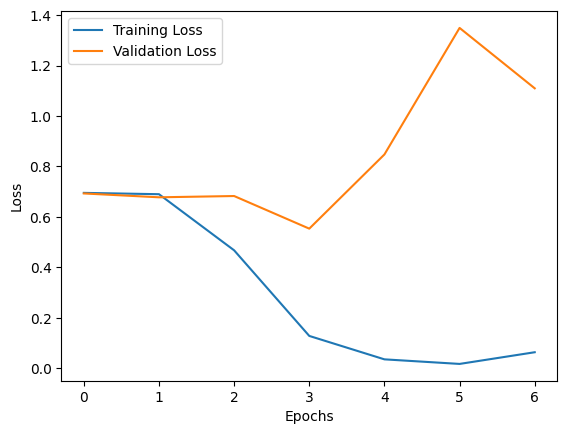

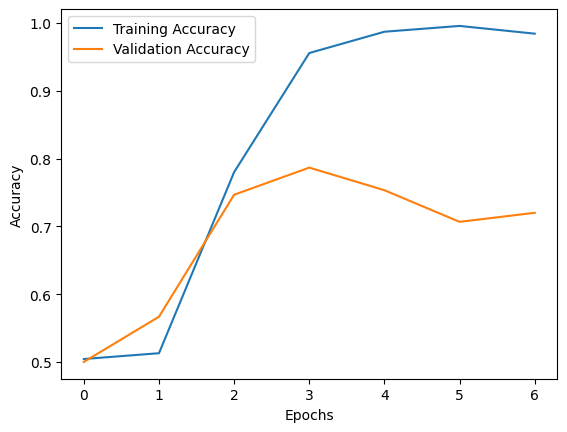

In [20]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_padded, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
train_padded, y_train,
validation_data=(val_padded, y_val),
epochs=20,
batch_size=32,
callbacks=[early_stopping]

# Save Model
model.save('sentiment_analysis_model.h5')

5/5 [==============================] - 0s 3ms/step - loss: 0.4219 - accuracy: 0.8067
Test Loss: 0.42188528180122375
Test Accuracy: 0.8066666722297668


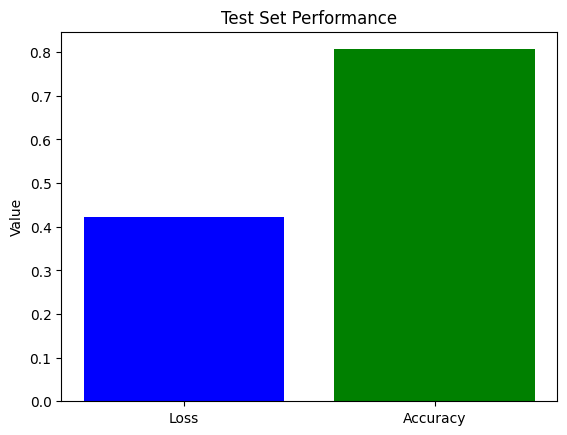

In [22]:
# Plot Test Set Metrics
metrics = ['Loss', 'Accuracy']
values = [test_loss, test_accuracy]
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Test Set Performance')
plt.ylabel('Value')
plt.show()
train_padded, y_train,
validation_data=(val_padded, y_val),
epochs=20,
batch_size=32,
callbacks=[early_stopping]

# Summary and Recommendations

The trained neural network was saved using the model.save() function in TensorFlow, which ensures the model, including its architecture, weights, and training configuration, can be efficiently reloaded for future use. The model was saved in the HDF5 format (.h5), which is highly portable and supports large datasets, enabling seamless deployment or further evaluation of the model.

The functionality of the Long Short-Term Memory (LSTM) neural network highlights its effectiveness for sentiment classification tasks. The architecture, comprising an embedding layer, an LSTM layer, a dropout layer, and a dense output layer, was designed to capture temporal dependencies and contextual relationships in sequential text data. The LSTM layer, in particular, addresses challenges such as vanishing gradients in long sequences, ensuring the model can retain and process contextual information effectively. The use of early stopping prevented overfitting, and the model's test accuracy of 80% demonstrated its ability to generalize well to unseen data.

Based on the results, the following course of action is recommended: businesses can leverage the model to analyze customer reviews and identify sentiment trends, enabling them to enhance customer satisfaction initiatives. Specific actions include prioritizing commonly mentioned areas for improvement, resolving frequently cited issues, and monitoring sentiment trends to evaluate the impact of new policies or products. These insights can inform strategic decision-making and improve overall customer engagement and satisfaction.

# Web Sources and References

Matplotlib. (n.d.). Creating visualizations in Python. Retrieved January 20, 2025, from https://matplotlib.org

NumPy. (n.d.). The fundamental package for scientific computing with Python. Retrieved January 20, 2025, from https://numpy.org

Pandas. (n.d.). Python data analysis library. Retrieved January 20, 2025, from https://pandas.pydata.org

Python Software Foundation. (n.d.). collections.Counter. Retrieved January 20, 2025, from https://docs.python.org/3/library/collections.html#collections.Counter

Scikit-Learn. (n.d.). Feature extraction with CountVectorizer. Retrieved January 20, 2025, from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Scikit-Learn. (n.d.). Machine learning in Python. Retrieved January 20, 2025, from https://scikit-learn.org

TensorFlow. (n.d.). Build and train machine learning models. Retrieved January 20, 2025, from https://www.tensorflow.org

TensorFlow. (n.d.). Dense layer. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

TensorFlow. (n.d.). Dropout layer. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

TensorFlow. (n.d.). EarlyStopping callback. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

TensorFlow. (n.d.). Embedding layer. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

TensorFlow. (n.d.). LSTM layer. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

TensorFlow. (n.d.). Sequential model API. Retrieved January 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

WordCloud. (n.d.). Generate word clouds in Python. Retrieved January 20, 2025, from https://github.com/amueller/word_cloud
